## Load Packages

In [1]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pkg_resources
import seaborn as sns
#sns.set_theme(style="ticks")

# import sklearn libararies
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor

#from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Flatten, Dense, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from numpy import mean
from numpy import std
from numpy import absolute

import lightgbm as lgb
import xgboost as xgb
import missingno as msno
from itertools import combinations_with_replacement

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="darkgrid")

## Data Handling

### Load Data

In [2]:
df = pd.read_excel('Wind_data.xlsx')

### Check the Data

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_tmp = df.copy()

# let's glimpse data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Columns: 114 entries, DATETIME to WS_921049
dtypes: datetime64[ns](1), float64(113)
memory usage: 3.2 MB


In [4]:
df.describe()

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,...,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
count,3635,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,...,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00,3635.00
mean,2019-10-22 23:15:08.170564096,0.19,4.53,3.94,5.12,5.12,5.56,2.52,3.93,3.39,...,5.13,4.69,5.46,4.79,6.08,4.86,5.76,5.96,5.70,5.44
min,2019-08-07 00:00:00,0.00,0.59,0.49,0.68,0.46,0.53,0.50,0.31,0.24,...,0.69,0.42,0.41,0.53,0.64,0.65,0.74,0.70,0.49,0.56
25%,2019-09-14 17:30:00,0.04,2.23,2.05,2.87,2.79,3.31,1.49,1.84,1.35,...,2.62,2.83,3.09,2.60,3.37,2.49,3.13,3.31,3.24,3.21
50%,2019-10-22 14:00:00,0.13,3.66,3.22,4.78,4.49,5.36,2.01,3.34,2.46,...,4.42,4.30,4.91,4.43,5.43,3.94,5.05,5.28,5.11,5.11
75%,2019-11-30 08:30:00,0.30,6.58,5.50,6.86,6.56,7.66,2.98,5.77,4.40,...,7.28,6.07,7.28,6.87,8.25,6.81,7.74,8.06,7.63,7.11
max,2020-01-07 23:00:00,0.73,14.66,13.13,14.64,23.04,17.43,13.20,11.81,19.15,...,15.47,15.78,16.71,13.53,19.80,15.99,22.66,18.91,16.64,18.08
std,NaN,0.17,2.79,2.37,2.71,3.21,2.69,1.66,2.40,2.83,...,2.99,2.48,3.01,2.56,3.39,2.96,3.50,3.32,3.14,2.80


In [5]:
df.sample(10)

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,...,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
2696,2019-11-29 03:00:00,0.03,2.28,2.07,6.59,3.82,1.31,2.16,0.66,6.67,...,3.01,3.55,3.06,0.86,3.24,3.09,2.87,3.08,3.49,3.11
1737,2019-10-19 06:00:00,0.26,6.53,5.71,5.26,6.67,5.56,2.20,1.24,1.93,...,6.83,5.04,7.41,3.06,9.80,6.08,6.72,9.66,9.10,7.50
2603,2019-11-25 06:00:00,0.21,0.93,0.90,5.04,1.47,7.23,0.98,6.66,1.22,...,1.13,4.71,4.86,7.06,5.59,1.02,1.57,6.35,6.16,6.23
2768,2019-12-02 03:00:00,0.02,2.19,1.47,6.97,3.97,3.46,1.26,1.80,9.60,...,2.97,7.15,5.31,1.59,4.21,2.91,4.09,4.40,6.28,5.50
2002,2019-10-31 04:00:00,0.03,2.02,2.33,5.27,3.86,3.91,1.33,0.97,2.93,...,1.46,1.56,1.74,1.76,3.66,2.11,2.82,3.20,1.65,2.20
1100,2019-09-22 17:00:00,0.50,8.94,7.31,7.63,8.94,9.00,4.93,8.45,4.90,...,9.99,6.47,6.11,8.45,6.95,10.17,10.65,7.06,6.40,7.17
2851,2019-12-05 14:00:00,0.01,1.47,1.38,4.56,2.96,2.75,1.84,2.16,1.05,...,1.87,3.28,3.11,1.92,2.73,1.36,3.61,2.79,3.37,3.23
3129,2019-12-17 05:00:00,0.21,2.06,1.73,3.82,4.46,8.23,2.67,6.59,1.58,...,3.10,6.79,7.25,8.38,7.02,2.26,4.02,8.34,8.27,8.35
262,2019-08-18 10:00:00,0.03,2.46,2.31,1.33,4.51,5.05,2.15,5.25,1.20,...,2.83,1.82,1.86,4.15,1.75,2.67,3.76,1.86,1.85,1.80
1686,2019-10-17 03:00:00,0.02,2.40,2.41,6.70,2.20,4.32,1.62,2.19,4.80,...,2.61,1.95,1.84,2.48,2.12,2.55,3.06,2.00,1.98,1.77


### Analyzing Missing Data

In [6]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent (NaN)'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

<Axes: >

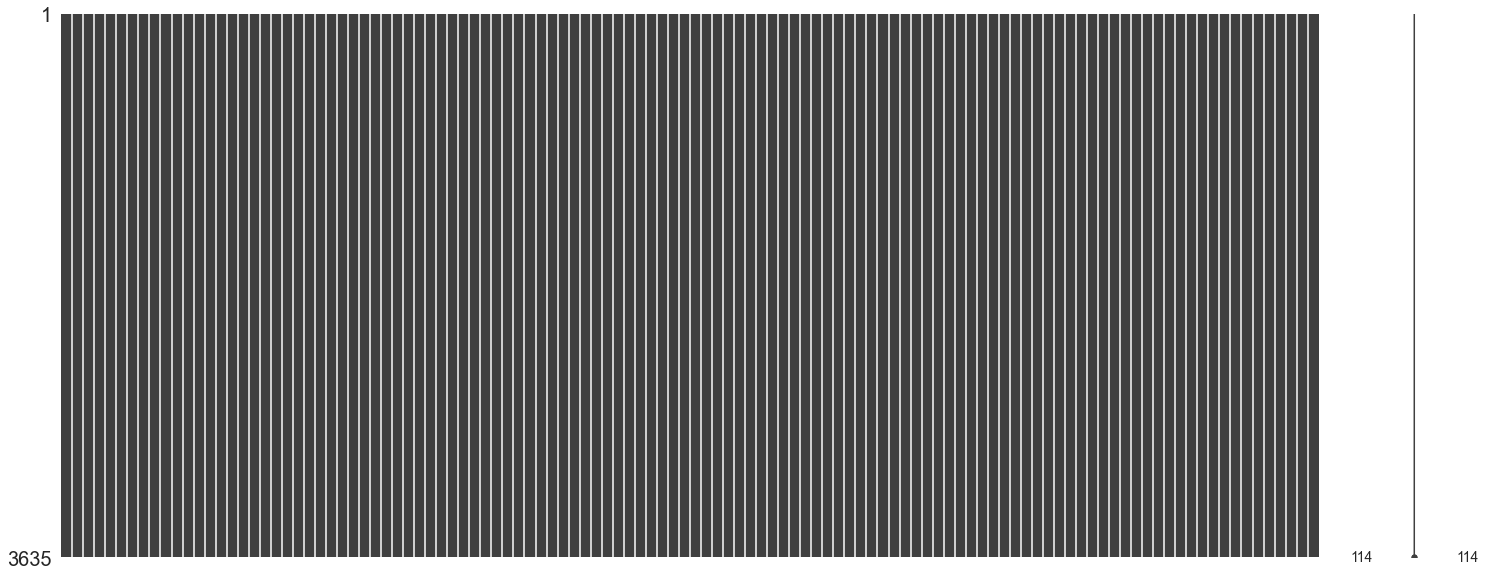

In [7]:
# Visualize missing data in dataset
msno.matrix(df)

### Percentage of missing data in each feature

In [8]:
missing_data(df)

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,...,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent (NaN),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Types,datetime64[ns],float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


### Check Correlation between Features

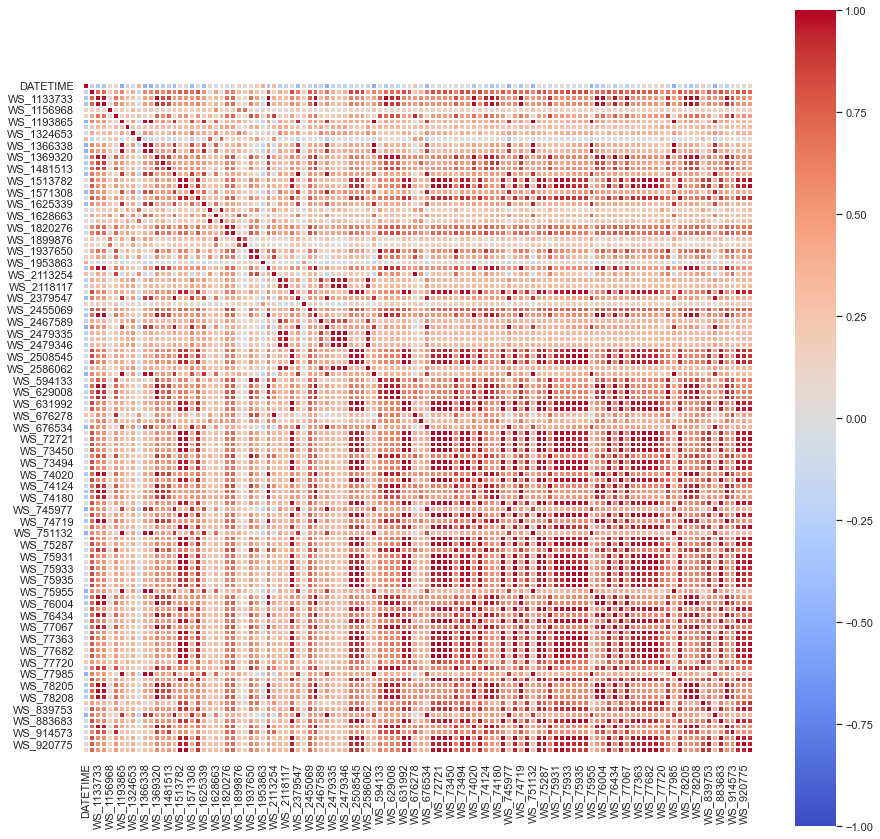

In [9]:
corr = df.corr()

fig, ax = plt.subplots(1, 1, figsize=(15,15))
sns.heatmap(corr, square=True, linecolor='white', linewidth=0.1, cmap='coolwarm', annot=False, vmax=1.0, vmin=-1.0)
plt.show()

In [10]:
pd.set_option('display.max_rows', None)

corr = df.corr()

# Sort by "CF" correlation
sorted_corr_CF = corr["CF"].sort_values(ascending=False)

# Print the sorted correlation values
print(sorted_corr_CF)

CF            1.00
WS_2503597    0.85
WS_2508550    0.84
WS_2508545    0.84
WS_75936      0.84
WS_75935      0.84
WS_75934      0.83
WS_77363      0.83
WS_631992     0.83
WS_2217107    0.83
WS_74022      0.83
WS_73494      0.82
WS_883683     0.82
WS_75933      0.82
WS_76888      0.82
WS_75287      0.82
WS_72733      0.82
WS_746023     0.82
WS_918665     0.81
WS_73822      0.81
WS_73450      0.80
WS_76275      0.80
WS_74243      0.80
WS_78026      0.80
WS_1574484    0.79
WS_72720      0.79
WS_75931      0.79
WS_651000     0.79
WS_75213      0.79
WS_77080      0.78
WS_839753     0.78
WS_72721      0.77
WS_77370      0.77
WS_77683      0.77
WS_2455069    0.76
WS_75932      0.76
WS_77682      0.76
WS_1513805    0.76
WS_920775     0.76
WS_1513782    0.75
WS_921049     0.73
WS_74020      0.73
WS_76004      0.73
WS_609612     0.73
WS_1133733    0.72
WS_74884      0.72
WS_1369320    0.72
WS_76434      0.72
WS_78208      0.72
WS_77067      0.72
WS_78205      0.72
WS_78207      0.72
WS_2460378  

In [11]:
# Calculate correlation
corr = df.corr()

# Filter features with correlation higher than 0.70
high_corr = corr[abs(corr['CF']) > 0.70].index

# Drop target variable 'CF' from the list of input features
high_corr = high_corr.drop('CF')

# Create a DataFrame with the selected features
df_high_corr = df[high_corr]

# Print the names of the selected features
print(high_corr)

Index(['WS_1133733', 'WS_1156770', 'WS_1369320', 'WS_1513782', 'WS_1513805',
       'WS_1574484', 'WS_1960535', 'WS_2217107', 'WS_2455069', 'WS_2460378',
       'WS_2503597', 'WS_2508545', 'WS_2508550', 'WS_609612', 'WS_631992',
       'WS_651000', 'WS_72720', 'WS_72721', 'WS_72733', 'WS_73450', 'WS_73494',
       'WS_73822', 'WS_74020', 'WS_74022', 'WS_74158', 'WS_74243', 'WS_746023',
       'WS_74719', 'WS_74884', 'WS_75213', 'WS_75287', 'WS_75931', 'WS_75932',
       'WS_75933', 'WS_75934', 'WS_75935', 'WS_75936', 'WS_76003', 'WS_76004',
       'WS_76275', 'WS_76434', 'WS_76888', 'WS_77067', 'WS_77080', 'WS_77363',
       'WS_77370', 'WS_77682', 'WS_77683', 'WS_78026', 'WS_78205', 'WS_78207',
       'WS_78208', 'WS_839753', 'WS_883683', 'WS_883699', 'WS_918665',
       'WS_920775', 'WS_921049'],
      dtype='object')


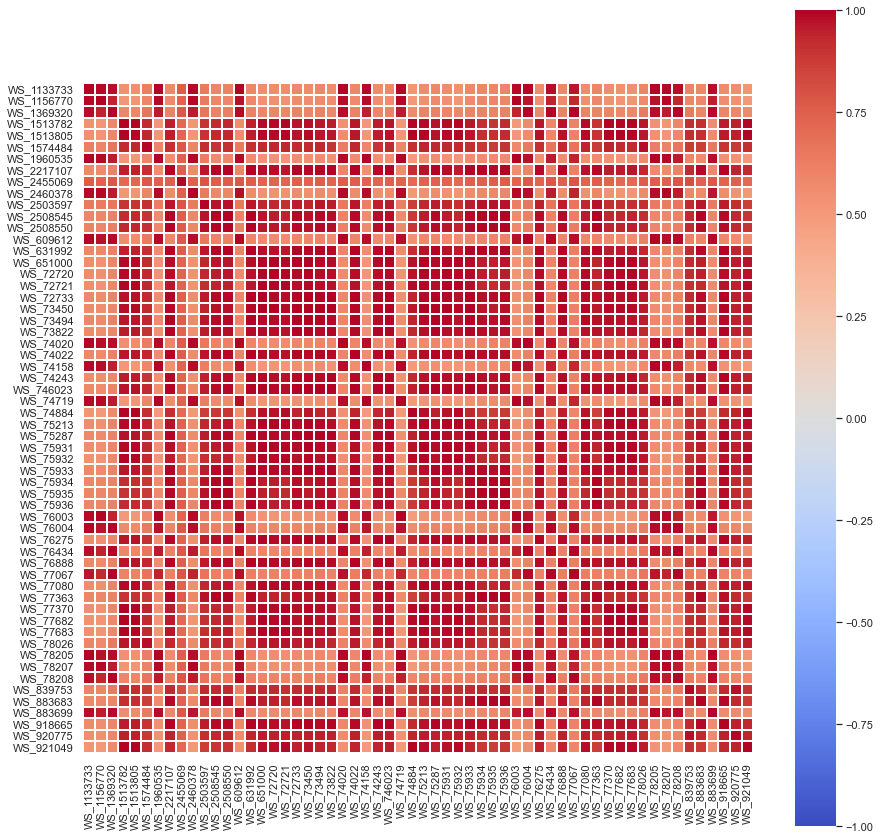

In [12]:
# Show correlation matrix
corr = df_high_corr.corr()

fig, ax = plt.subplots(1, 1, figsize=(15,15))
sns.heatmap(corr, square=True, linecolor='white', linewidth=0.1, cmap='coolwarm', annot=False, vmax=1.0, vmin=-1.0)
plt.show()

## Data Exploration for Each Column

In [13]:
# Define bins to cut CF into
bins = np.arange(0, df['CF'].max() + 0.1, 0.1) 

# Use pd.cut to cut CF into bins and add the CLASS column
df['CLASS'] = pd.cut(df['CF'], bins=bins, labels=False, include_lowest=True, right=False)

In [14]:
# Create empty lists
dfs_wells = []
classnames = []

grouped = df.groupby("CLASS")

#split up the data by well
for well, data in grouped:
    dfs_wells.append(data)
    classnames.append(well)

In [15]:
def create_plot(classname, dataframe, 
                curves_to_plot, depth_curve, 
                log_curves=[]):
    
    # Count the number of tracks we need
    num_tracks = len(curves_to_plot)
    
    # Setup the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=num_tracks, figsize=(num_tracks*2, 10))
    
    # Create a super title for the entire plot
    fig.suptitle(classname, fontsize=20, y=1.05)
    
    # Loop through each curve in curves_to_plot and create a track with that data
    for i, curve in enumerate(curves_to_plot):
        
        
        ax[i].plot(dataframe[curve], depth_curve)
        
        # Setup a few plot cosmetics
        ax[i].set_title(curve, fontsize=14, fontweight='bold')
        ax[i].grid(which='major', color='lightgrey', linestyle='-')
        
        # We want to pass in the deepest depth first, so we are displaying the data 
        # from shallow to deep
        ax[i].set_ylim(depth_curve.max(), depth_curve.min())

        # Only set the y-label for the first track. Hide it for the rest
        if i == 0:
            ax[i].set_ylabel('DATETIME', fontsize=18, fontweight='bold')
        else:
            plt.setp(ax[i].get_yticklabels(), visible = False)
        
        # Check to see if we have any logarithmic scaled curves
        if curve in log_curves:
            ax[i].set_xscale('log')
            ax[i].grid(which='minor', color='lightgrey', linestyle='-')
    
    plt.tight_layout()
    plt.show()

### Histogram

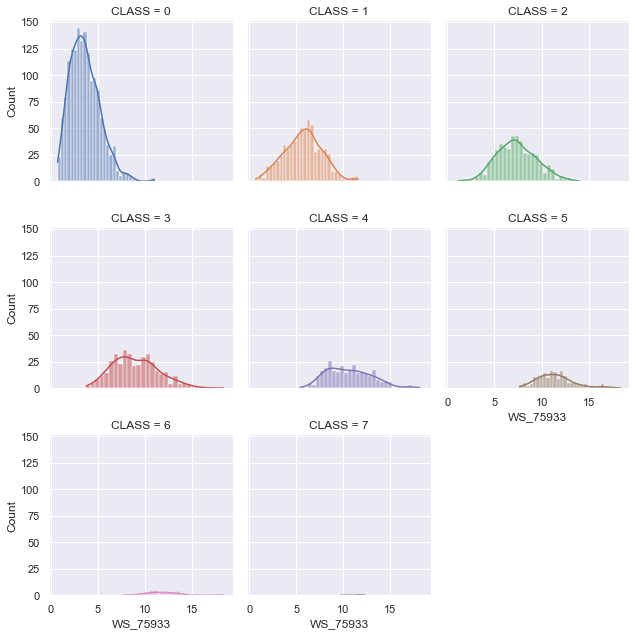

In [16]:
g = sns.FacetGrid(df, col='CLASS', hue='CLASS', col_wrap=3)
g.map(sns.histplot, 'WS_75933', kde=True, bins=30)

### Boxplot

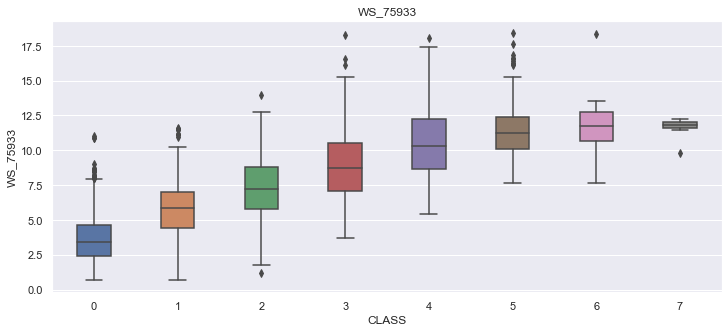

In [17]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
# Boxplot of Gamma Ray Per Well
sns.boxplot(data=df, x='CLASS', y='WS_75933', hue='CLASS', dodge =False, width=0.4 )
ax.set_title('WS_75933')
ax.get_legend().remove()

### Let's look at the characteristics of data together

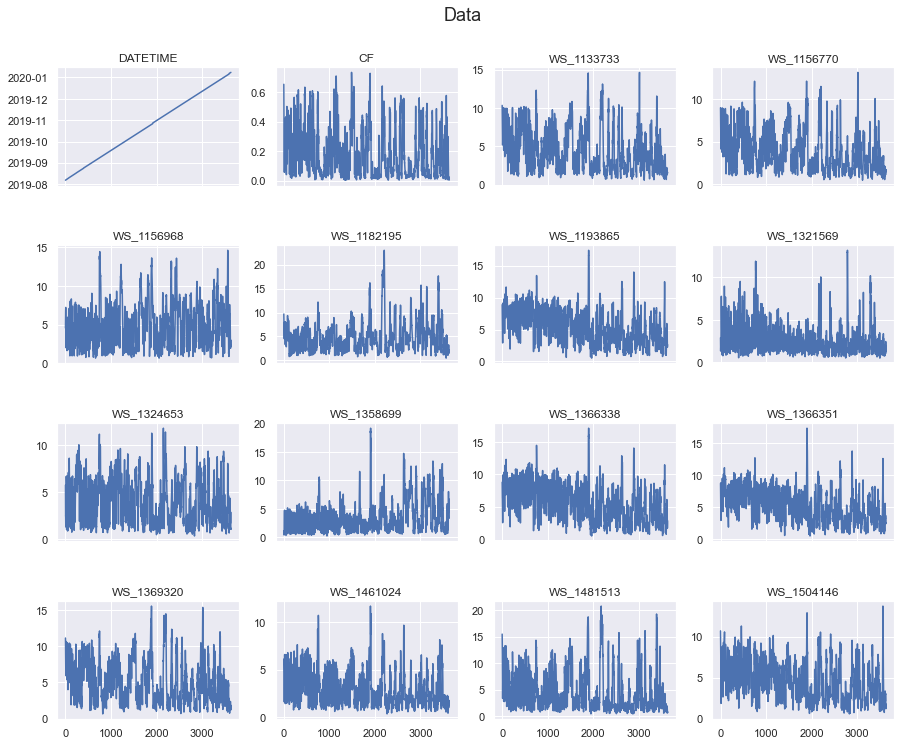

In [18]:
# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 12), sharex=True) 
plt.subplots_adjust(hspace=0.5) 
fig.suptitle("Data", fontsize=18, y=0.95)


# loop through tickers and axes
col_names = df.columns
for col_name, ax in zip(col_names, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df[col_name].plot(ax=ax)

    # chart formatting
    ax.set_title(col_name.upper())

plt.show()

### Removing outlier

In [19]:
def remove_outlier(df, col_name):
    """
    Remove outlier in each features by replacing outliers to NAN
    df : dataframe
    col_name : string / column name
    """
    # define outlieer as larger/smaller by 3 standard deviation of each column data
    upper_limit = df[col_name].mean() + 3*df[col_name].std()
    lower_limit = df[col_name].mean() - 3*df[col_name].std()
    
    # mask as a NaN
    df[col_name] = np.where(df[col_name]>=upper_limit,
                     np.nan,
                     np.where(df[col_name]<=lower_limit,
                              np.nan,
                              df[col_name])
                    )

In [20]:
df_trim = df.copy()
remove_outlier(df_trim, col_names)   

Text(0.5, 1.0, 'No outlier')

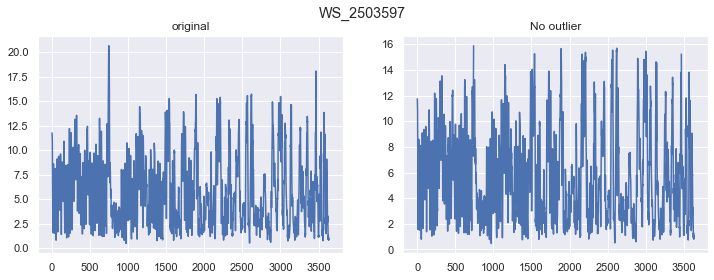

In [21]:
#comparing with / without outlier

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

fig.suptitle('WS_2503597')

ax1.plot(df['WS_2503597'])
ax1.set_title('original')

ax2.plot(df_trim['WS_2503597'])
ax2.set_title('No outlier')

In [22]:
remove_outlier(df, col_names)  

### Filtering Nan based on Target Columns

In [23]:
df_no = df[['CF']].dropna()

In [24]:
df_nonan = df.iloc[df_no.index]

In [25]:
# check the NaN in each feature
for col in df.columns:
    print(col, df_nonan[col].isna().sum())

DATETIME 0
CF 0
WS_1133733 13
WS_1156770 23
WS_1156968 24
WS_1182195 86
WS_1193865 16
WS_1321569 79
WS_1324653 6
WS_1358699 58
WS_1366338 13
WS_1366351 16
WS_1369320 15
WS_1461024 39
WS_1481513 45
WS_1504146 7
WS_1513782 34
WS_1513805 33
WS_1571308 1
WS_1574484 22
WS_1625339 24
WS_1625374 87
WS_1628663 44
WS_1681085 88
WS_1820276 31
WS_1820279 22
WS_1899876 56
WS_1911282 23
WS_1937650 15
WS_1937653 48
WS_1953863 8
WS_1960535 12
WS_2113254 51
WS_2113394 18
WS_2118117 25
WS_2217107 17
WS_2379547 8
WS_2385763 4
WS_2455069 0
WS_2460378 14
WS_2467589 16
WS_2467635 3
WS_2479335 21
WS_2479342 25
WS_2479346 21
WS_2503597 15
WS_2508545 12
WS_2508550 13
WS_2586062 20
WS_593968 13
WS_594133 16
WS_609612 13
WS_629008 23
WS_629020 24
WS_631992 13
WS_651000 25
WS_676278 63
WS_676403 47
WS_676534 4
WS_72720 21
WS_72721 29
WS_72733 19
WS_73450 19
WS_73451 22
WS_73494 12
WS_73822 20
WS_74020 16
WS_74022 10
WS_74124 24
WS_74158 12
WS_74180 32
WS_74243 20
WS_745977 4
WS_746023 19
WS_74719 12
WS_74884 35


<Axes: >

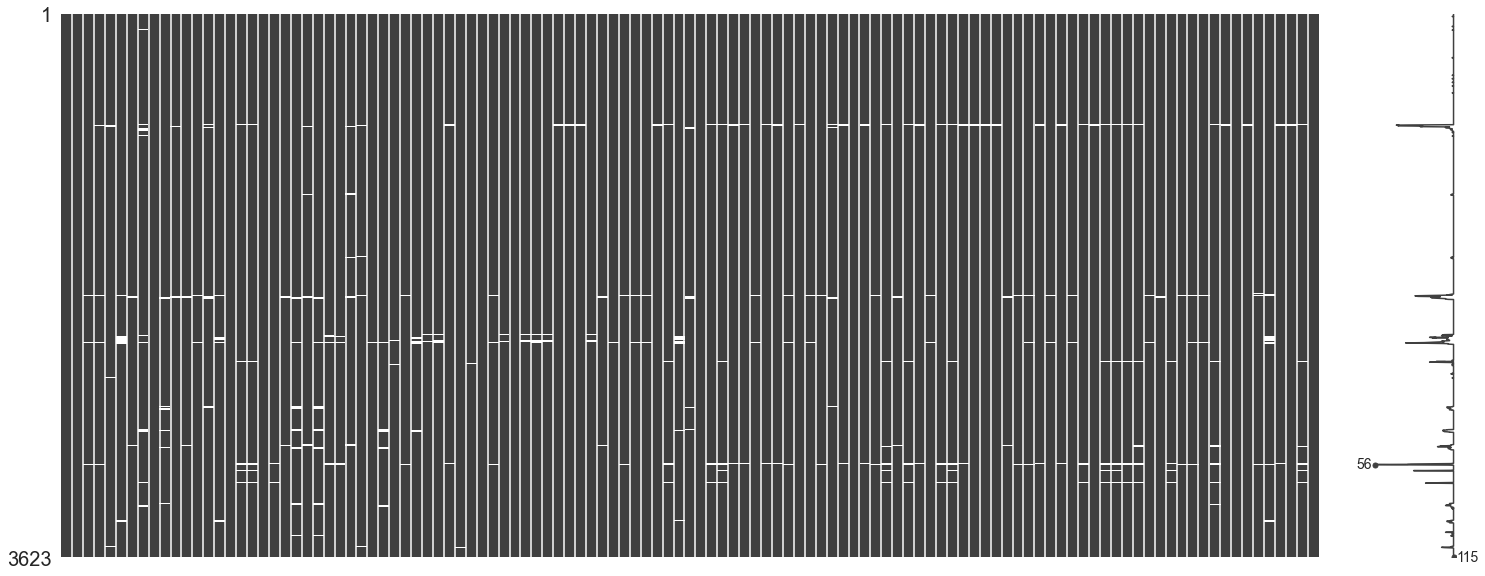

In [26]:
# visualize the reduced valid dataset 
msno.matrix(df_nonan)

In [27]:
missing_data(df_nonan)

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,...,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049,CLASS
Total,0,0,13,23,24,86,16,79,6,58,...,46,18,4,14,17,82,20,15,35,0
Percent (NaN),0.00,0.00,0.36,0.63,0.66,2.37,0.44,2.18,0.17,1.60,...,1.27,0.50,0.11,0.39,0.47,2.26,0.55,0.41,0.97,0.00
Types,datetime64[ns],object,object,object,object,object,object,object,object,object,...,object,object,object,object,object,object,object,object,object,object


In [28]:
df_nonan.columns

Index(['DATETIME', 'CF', 'WS_1133733', 'WS_1156770', 'WS_1156968',
       'WS_1182195', 'WS_1193865', 'WS_1321569', 'WS_1324653', 'WS_1358699',
       ...
       'WS_811655', 'WS_839753', 'WS_875373', 'WS_883683', 'WS_883699',
       'WS_914573', 'WS_918665', 'WS_920775', 'WS_921049', 'CLASS'],
      dtype='object', length=115)

In [29]:
df_nonan = df_nonan.drop(columns=['DATETIME'])
data = df_nonan.dropna()
print(data.columns)
print(data.shape)

Index(['CF', 'WS_1133733', 'WS_1156770', 'WS_1156968', 'WS_1182195',
       'WS_1193865', 'WS_1321569', 'WS_1324653', 'WS_1358699', 'WS_1366338',
       ...
       'WS_811655', 'WS_839753', 'WS_875373', 'WS_883683', 'WS_883699',
       'WS_914573', 'WS_918665', 'WS_920775', 'WS_921049', 'CLASS'],
      dtype='object', length=114)
(3240, 114)


<Axes: >

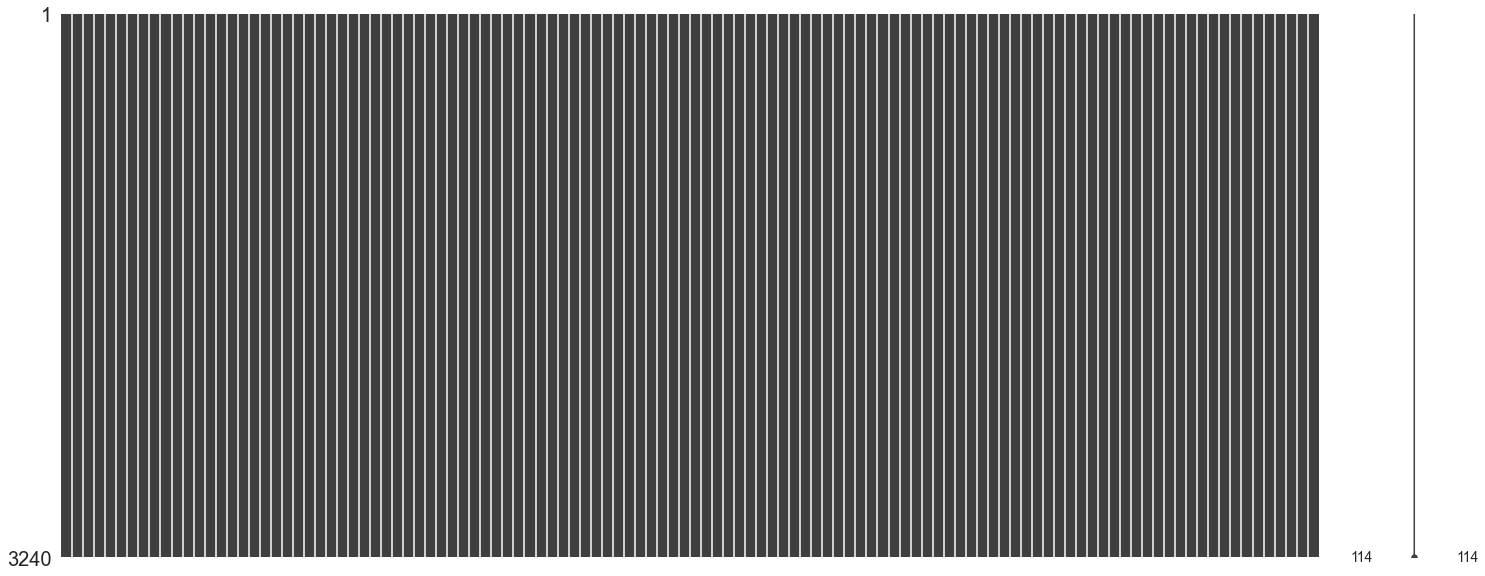

In [30]:
msno.matrix(data)

## Build Machine Learning Models

### Splitting the Dataset into Training and Testing Sets

In [31]:
# Create feature matrix X and target variable y
X = data.drop(columns=['CF']).values
Y = data['CF'].values
print(X.shape, Y.shape)

(3240, 113) (3240,)


### Standardizing the Data

In [32]:
# standize the matrix for training data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

print("X_train: ", X_train.shape , ", y_train: ",y_train.shape)
print("X_test: ", X_test.shape , ", y_test: ",y_test.shape)

X_train:  (2592, 113) , y_train:  (2592,)
X_test:  (648, 113) , y_test:  (648,)


## Model Training - Random Forest

In [34]:
# Define the model 
model_RF = RandomForestRegressor(random_state=0)

# Define the parameters for the grid search
param_grid_RF = {
    'n_estimators': [100],
    'max_depth': [100],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

# Define the cross-validation method
cv = RepeatedKFold(n_splits=5,  random_state=123)

# Set up the grid search
grid_RF = GridSearchCV(model_RF, 
                    param_grid=param_grid_RF, 
                    scoring='neg_mean_absolute_error', 
                    cv=cv, 
                    n_jobs=-1)

# Fit the model
grid_RF.fit(X_train, y_train)

# Create a DataFrame with the results
scores_df_RF = pd.DataFrame(grid_RF.cv_results_)

# Print best parameters after tuning 
print(grid_RF.best_params_) 

{'bootstrap': True, 'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [35]:
# Save the results to a csv file
scores_df_RF.to_csv("random_forest_gridsearch.csv")

# Print scores
print(scores_df_RF.transpose())

                                                                         0
mean_fit_time                                                        77.71
std_fit_time                                                          5.05
mean_score_time                                                       0.03
std_score_time                                                        0.01
param_bootstrap                                                       True
param_max_depth                                                        100
param_min_samples_leaf                                                   1
param_min_samples_split                                                  2
param_n_estimators                                                     100
params                   {'bootstrap': True, 'max_depth': 100, 'min_sam...
split0_test_score                                                    -0.02
split1_test_score                                                    -0.02
split2_test_score        

In [36]:
# Initialize the model with the best parameters
model_RF = RandomForestRegressor(**grid_RF.best_params_)

# Fit the model to the training data
model_RF.fit(X_train, y_train)

# Predict the targets for the test data
y_pred_RF = model_RF.predict(X_test)

# Calculate the mean absolute error of the model
mae_RF = mean_absolute_error(y_test, y_pred_RF)

print(f'Test MAE: {mae_RF}')

Test MAE: 0.014948603364060595


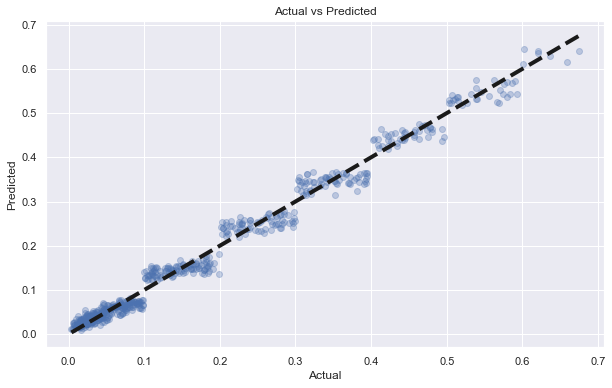

In [37]:
# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_RF, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

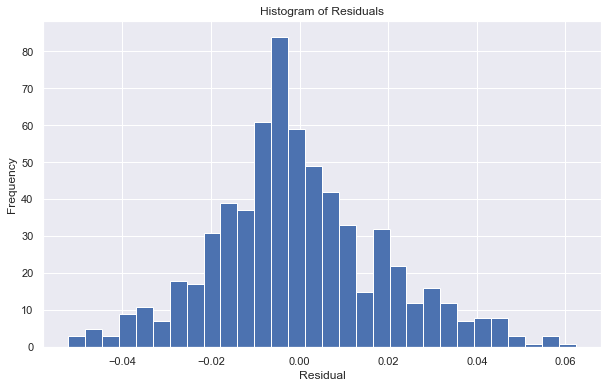

In [38]:
# Calculate residuals
residuals_RF = y_test - y_pred_RF

# Plot histogram of residuals
plt.figure(figsize=(10,6))
plt.hist(residuals_RF, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## Model Training - LGBM

In [39]:
# Define the model 
model_lgbm = lgb.LGBMRegressor()

# Define the parameters for the grid search
param_grid_lgbm = {'estimator__n_estimator': [200],
              'estimator__num_leaves' : [10],
              'estimator__max_depth' : [-1],
              'estimator__min_child_samples' : [20, 40],
              'estimator__subsample' : [1],
              'estimator__learning_rate' : [0.05]}

#param_grid_lgbm = {'estimator__n_estimator': [200, 400, 800, 1000, 1200],
#              'estimator__num_leaves' : [10, 20, 40, 50, 60, 70, 80, 90, 100],
#              'estimator__max_depth' : [-1],
#              'estimator__min_child_samples' : [20, 40, 60],
#              'estimator__subsample' : [1],
#              'estimator__learning_rate' : [0.05]}

cv = RepeatedKFold(n_splits=5,  random_state=123)

grid_lgbm = GridSearchCV(model_lgbm, 
                    param_grid=param_grid_lgbm,
                    scoring='neg_mean_absolute_error', 
                    cv=cv, 
                    n_jobs=-1)

grid_lgbm.fit(X_train,y_train)

scores_df_lgbm = pd.DataFrame(grid_lgbm.cv_results_)

# print best parameter after tuning 
print(grid_lgbm.best_params_) 

[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__min_child_samples
[LightGBM] [Warning] Unknown parameter: estimator__n_estimator
[LightGBM] [Warning] Unknown parameter: estimator__num_leaves
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__min_child_samples
[LightGBM] [Warning] Unknown parameter: estimator__n_estimator
[LightGBM] [Warning] Unknown parameter: estimator__num_leaves
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28568
[LightGBM] [Info] Number of data point

In [40]:
# save to csv
scores_df_lgbm.to_csv("light_gbm_grisearch.csv")

# print scores
print(scores_df_lgbm.transpose())

                                                                                    0  \
mean_fit_time                                                                   12.25   
std_fit_time                                                                     4.51   
mean_score_time                                                                  0.04   
std_score_time                                                                   0.09   
param_estimator__learning_rate                                                   0.05   
param_estimator__max_depth                                                         -1   
param_estimator__min_child_samples                                                 20   
param_estimator__n_estimator                                                      200   
param_estimator__num_leaves                                                        10   
param_estimator__subsample                                                          1   
params               

In [42]:
# Initialize the model with the best parameters
model_lgbm = lgb.LGBMRegressor(**grid_lgbm.best_params_)

# Fit the model to the training data
model_lgbm.fit(X_train, y_train)

# Predict the targets for the test data
y_pred_lgbm= model_lgbm.predict(X_test)

# Calculate the mean absolute error of the model
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

print(f'Test MAE: {mae_lgbm}')

[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__min_child_samples
[LightGBM] [Warning] Unknown parameter: estimator__n_estimator
[LightGBM] [Warning] Unknown parameter: estimator__num_leaves
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__min_child_samples
[LightGBM] [Warning] Unknown parameter: estimator__n_estimator
[LightGBM] [Warning] Unknown parameter: estimator__num_leaves
[LightGBM] [Warning] Unknown parameter: estimator__subsample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28568
[LightGBM] [Info] Number of data point

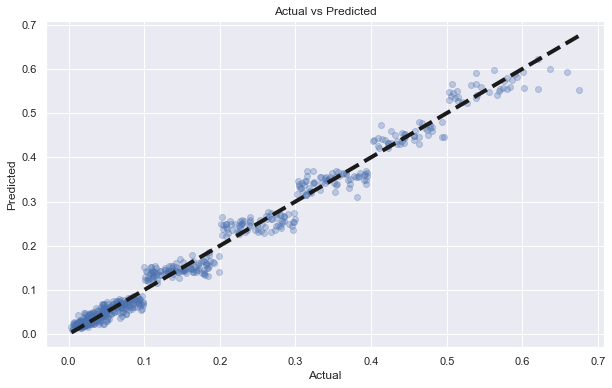

In [43]:
# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_lgbm, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

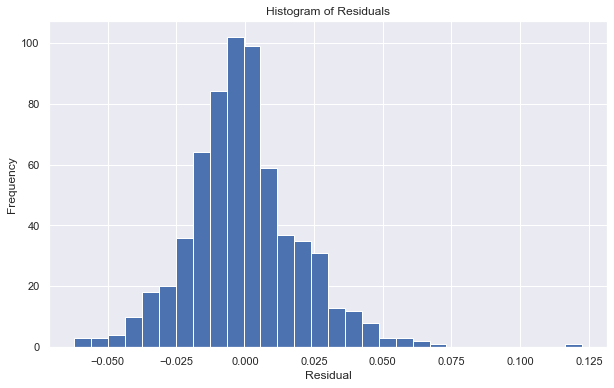

In [44]:
# Calculate residuals
residuals_lgbm = y_test - y_pred_lgbm

# Plot histogram of residuals
plt.figure(figsize=(10,6))
plt.hist(residuals_lgbm, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## Model Training - XGBoost

In [45]:
# Define the model 
model_xgb = xgb.XGBRegressor()

# Define the parameters for the grid search
param_grid_xgb = {'estimator__learning_rate' : [0.01],
              'estimator__n_estimator': [200],
              'estimator__max_depth' : [3],
              'estimator__max_leaf_nodes': [100],
              'estimator__min_child_weight' : [1],
              'estimator__colsample_bytree' : [0.3],
              'estimator__subsample' : [1],
              'estimator__reg_lamda' : [1],
              'estimator__reg_alpha' : [0.00]}

#param_grid_xgb = {'estimator__learning_rate' : [0.01, 0.05, 0.1],
#              'estimator__n_estimator': [200, 800, 1600],
#              'estimator__max_depth' : [3, 6, 10, 20],
#              'estimator__max_leaf_nodes': [100],
#              'estimator__min_child_weight' : [1],
#              'estimator__colsample_bytree' : [0.3, 0.7, 1.0],
#              'estimator__subsample' : [1],
#              'estimator__reg_lamda' : [1],
#              'estimator__reg_alpha' : [0.00]}


cv = RepeatedKFold(n_splits=5,  random_state=123)

grid_xgb = GridSearchCV(model_xgb, 
             param_grid=param_grid_xgb,
             scoring='neg_mean_absolute_error',
             cv=cv, # cv, 
             n_jobs=-1)

grid_xgb.fit(X_train,y_train)

scores_df_xgb = pd.DataFrame(grid_xgb.cv_results_)

# print best parameter after tuning 
print(grid_xgb.best_params_) 

[07:44:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__max_leaf_nodes", "estimator__min_child_weight", "estimator__n_estimator", "estimator__reg_alpha", "estimator__reg_lamda", "estimator__subsample" } are not used.

{'estimator__colsample_bytree': 0.3, 'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__max_leaf_nodes': 100, 'estimator__min_child_weight': 1, 'estimator__n_estimator': 200, 'estimator__reg_alpha': 0.0, 'estimator__reg_lamda': 1, 'estimator__subsample': 1}


In [46]:
# save to csv
scores_df_xgb.to_csv("xgb_grisearch.csv")

# print scores
print(scores_df_xgb.transpose())

                                                                                   0
mean_fit_time                                                                   8.55
std_fit_time                                                                    1.48
mean_score_time                                                                 0.01
std_score_time                                                                  0.00
param_estimator__colsample_bytree                                               0.30
param_estimator__learning_rate                                                  0.01
param_estimator__max_depth                                                         3
param_estimator__max_leaf_nodes                                                  100
param_estimator__min_child_weight                                                  1
param_estimator__n_estimator                                                     200
param_estimator__reg_alpha                                       

In [48]:
# Initialize the model with the best parameters
model_xgb = xgb.XGBRegressor(**grid_xgb.best_params_)

# Fit the model to the training data
model_xgb.fit(X_train, y_train)

# Predict the targets for the test data
y_pred_xgb = model_xgb.predict(X_test)

# Calculate the mean absolute error of the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f'Test MAE: {mae_xgb}')

[07:44:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "estimator__colsample_bytree", "estimator__learning_rate", "estimator__max_depth", "estimator__max_leaf_nodes", "estimator__min_child_weight", "estimator__n_estimator", "estimator__reg_alpha", "estimator__reg_lamda", "estimator__subsample" } are not used.

Test MAE: 0.015829630769050782


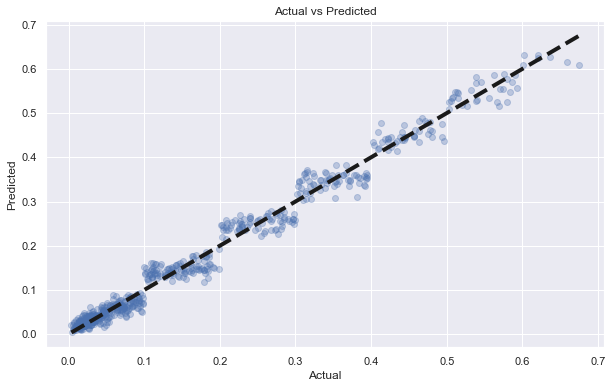

In [49]:
# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

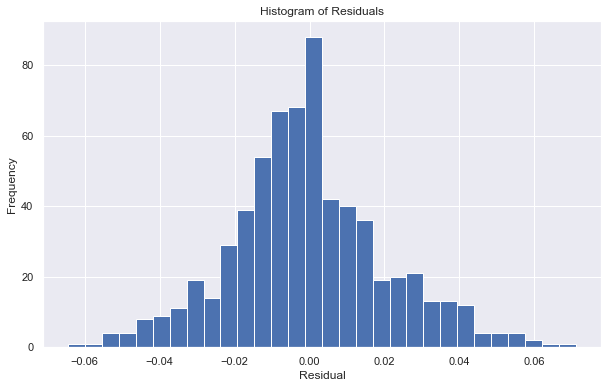

In [50]:
# Calculate residuals
residuals_xgb = y_test - y_pred_xgb

# Plot histogram of residuals
plt.figure(figsize=(10,6))
plt.hist(residuals_xgb, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## Model Training - CNN

In [71]:
# Reshaping data
X_train_CNN = X_train.reshape(-1, X_train.shape[1], 1)
y_train = y_train.astype('float32')

In [72]:
# Hyperparameters to tune
neurons = [8, 16, 32, 64, 128, 256]

# Set early stopping criteria
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

best_mae_cnn = np.inf
best_neurons_cnn = None
best_model_cnn = None

In [73]:
for n in neurons:
    model_cnn = Sequential()
    model_cnn.add(Conv1D(n, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model_cnn.add(MaxPooling1D(pool_size=2))
    model_cnn.add(Conv1D(n, kernel_size=3, activation='relu'))
    model_cnn.add(MaxPooling1D(pool_size=2))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(n, activation='relu'))
    model_cnn.add(Dropout(0.2))
    model_cnn.add(Dense(1))
    model_cnn.compile(optimizer=Adam(), loss='mean_absolute_error')

    model_cnn.fit(X_train_CNN, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[earlystopping], verbose=0)

    # Get predictions on train set and calculate MAE
    train_predictions_cnn = model_cnn.predict(X_train)
    mae_cnn = mean_absolute_error(y_train, train_predictions_cnn)

    print(f'Neurons: {n}, Train MAE: {mae_cnn}')
    
    # If current MAE is better than previous best, update best MAE and save model
    if mae_cnn < best_mae_cnn:
        best_mae_cnn = mae_cnn
        best_neurons_cnn = n
        best_model_cnn = model_cnn

Epoch 43: early stopping
81/81 [==============================] - 0s 2ms/step
Neurons: 8, Train MAE: 0.031665556132793427
Epoch 55: early stopping
81/81 [==============================] - 0s 3ms/step
Neurons: 16, Train MAE: 0.02509145438671112
Epoch 52: early stopping
81/81 [==============================] - 0s 2ms/step
Neurons: 32, Train MAE: 0.020699068903923035
Epoch 36: early stopping
81/81 [==============================] - 0s 3ms/step
Neurons: 64, Train MAE: 0.018097802996635437
Epoch 52: early stopping
81/81 [==============================] - 1s 5ms/step
Neurons: 128, Train MAE: 0.016453687101602554
Epoch 52: early stopping
81/81 [==============================] - 1s 11ms/step
Neurons: 256, Train MAE: 0.01954941265285015


In [74]:
print(f'Best Model, Neurons: {best_neurons_cnn}, Train MAE: {best_mae_cnn}')

Best Model, Neurons: 128, Train MAE: 0.016453687101602554


In [75]:
# Reshape X_test
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

# Use the best model to make predictions on the test set
y_pred_cnn = best_model_cnn.predict(X_test_cnn)

# Calculate MAE on the test set
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)

print(f'Test MAE: {mae_cnn}')

21/21 [==============================] - 0s 6ms/step
Test MAE: 0.02410121793911781


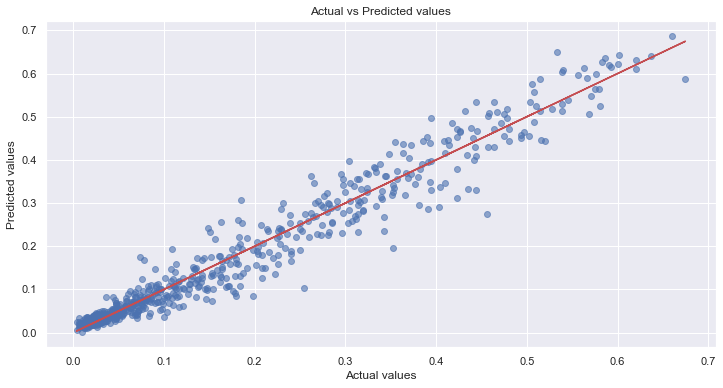

In [76]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_cnn, alpha=0.6)
plt.plot(y_test, y_test, 'r')
plt.title('Actual vs Predicted values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()

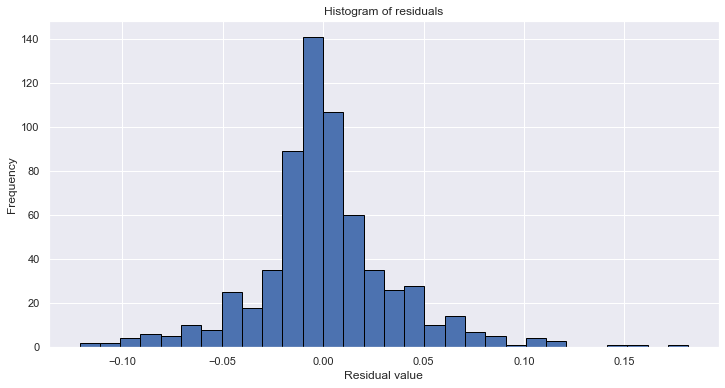

In [77]:
# Calculate residuals
residuals_cnn = y_test - y_pred_cnn.flatten()

# Plot histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals_cnn, bins=30, edgecolor='black')
plt.title('Histogram of residuals')
plt.xlabel('Residual value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Model Training - LSTM

In [78]:
# Hyperparameters to tune
neurons = [8, 16, 32, 64, 128, 256]

In [79]:
# Set early stopping criteria
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

best_mae_lstm = np.inf
best_neurons_lstm = None
best_model_lstm = None

In [81]:
for n in neurons:
    X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
    
    model_lstm = Sequential()
    model_lstm.add(LSTM(n, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(LSTM(n, activation='relu'))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(n, activation='relu'))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer=Adam(), loss='mean_absolute_error')

    model_lstm.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[earlystopping], verbose=0)

    # Get predictions on train set and calculate MAE
    train_predictions = model_lstm.predict(X_train_lstm)
    mae_lstm = mean_absolute_error(y_train, train_predictions)

    print(f'Neurons: {n}, Train MAE: {mae_lstm}')

    # If current MAE is better than previous best, update best MAE and save model
    if mae_lstm < best_mae_lstm:
        best_mae_lstm = mae_lstm
        best_neurons_lstm = n
        best_model_lstm = model_lstm

print(f'Best Model, Neurons: {best_neurons_lstm}, Train MAE: {best_mae_lstm}')

Epoch 25: early stopping
81/81 [==============================] - 0s 2ms/step
Neurons: 8, Train MAE: 0.025879621505737305
Epoch 23: early stopping
81/81 [==============================] - 0s 2ms/step
Neurons: 16, Train MAE: 0.03134773299098015
Epoch 37: early stopping
81/81 [==============================] - 0s 2ms/step
Neurons: 32, Train MAE: 0.019303791224956512
Epoch 23: early stopping
81/81 [==============================] - 1s 2ms/step
Neurons: 64, Train MAE: 0.017560478299856186
Epoch 20: early stopping
81/81 [==============================] - 1s 3ms/step
Neurons: 128, Train MAE: 0.017594991251826286
Epoch 57: early stopping
81/81 [==============================] - 1s 5ms/step
Neurons: 256, Train MAE: 0.012758975848555565
Best Model, Neurons: 256, Train MAE: 0.012758975848555565


In [83]:
# Testing on X_test similar to the CNN model
X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

y_pred_lstm = best_model_lstm.predict(X_test_lstm)

mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print(f'Test MAE: {mae_lstm}')

21/21 [==============================] - 0s 4ms/step
Test MAE: 0.01645712790519178


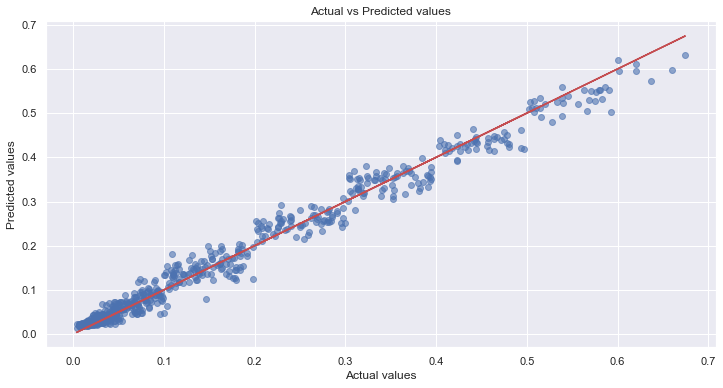

In [84]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_lstm, alpha=0.6)
plt.plot(y_test, y_test, 'r')
plt.title('Actual vs Predicted values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()

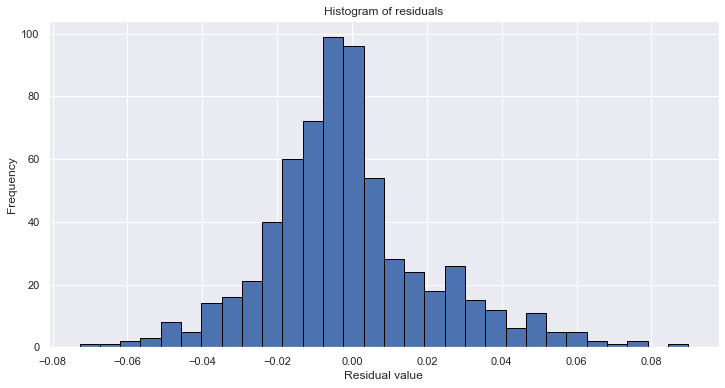

In [85]:
# Calculate residuals
residuals_lstm = y_test - y_pred_lstm.flatten()

# Plot histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals_lstm, bins=30, edgecolor='black')
plt.title('Histogram of residuals')
plt.xlabel('Residual value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Summary Table

In [90]:
pd.set_option('display.float_format', '{:.5f}'.format)

# Create a dictionary to store the MAE
data = {'Random Forest': [mae_RF],
        'Light GBM': [mae_lgbm],
        'XG Boost': [mae_xgb],
        'CNN': [mae_cnn],
        'LSTM': [mae_lstm]}

# Convert the dictionary to a pandas DataFrame
df_mae = pd.DataFrame(data, index=['MAE'])

# Print the DataFrame
print(df_mae)

     Random Forest  Light GBM  XG Boost     CNN    LSTM
MAE        0.01495    0.01517   0.01583 0.02410 0.01646
